## 市场宽度
*对市场内股票数据进行统计，观察样本变化。*

## 目录
1. 什么是市场宽度？
2. 数据预处理
3. 市场宽度计算公式
4. 如何用图形展示市场宽度？

## 1_什么是市场宽度？
市场宽度指标指某一日收盘时，显示某指数组合的股票的上涨数量与下跌数量的比率，有比较准确预测大盘行情的功能。

### 怎么计算市场宽度？

**1. Advance & Decline Percent (Participation)**

$\frac{(Advance-Decline)}{Total}$

**2. High & Low Percent (Leadership)**

$\frac{(High-Low)}{Total}$

**3. MA50_up & MA50_down Percent (Trend)**

$\frac{(MA50_{up}-MA50_{down})}{Total}$

## 2_数据预处理

In [1]:
from jaqs_fxdayu.data import DataView
from jaqs_fxdayu.data import RemoteDataService
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

C:\Users\WJ\Anaconda3\lib\importlib\__init__.py:126: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _bootstrap._gcd_import(name[level:], package, level)


Dataview loaded successfully.


In [2]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df

In [3]:
def formula(positive, negative, total):
    return (positive-negative)/total

def sumrows(frame):
    return frame.sum(axis=1)

In [4]:
mask = dv.get_ts('index_member')

In [5]:
PN = pd.Panel({'high' : change_index(dv.get_ts('high_adj').loc[20150105:][mask==1].dropna(how='all',axis=1)),
 'low' : change_index(dv.get_ts('low_adj').loc[20150105:][mask==1].dropna(how='all',axis=1)),
 'close' : change_index(dv.get_ts('close_adj').loc[20150105:][mask==1].dropna(how='all',axis=1)),
 'volume' : change_index(dv.get_ts('volume').loc[20150105:])[mask==1].dropna(how='all',axis=1)})

In [6]:
print(PN)

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 732 (major_axis) x 436 (minor_axis)
Items axis: close to volume
Major_axis axis: 2015-01-05 00:00:00 to 2017-12-29 00:00:00
Minor_axis axis: 000001.SZ to 603993.SH


In [7]:
PN = PN.transpose(2,1,0)

## 3_市场宽度计算公式

In [8]:
# cpc = close price 相对于前一天的涨跌幅
cpc = PN.minor_xs('close').pct_change()

participation = formula(
    sumrows(cpc>0),
    sumrows(cpc<0),
    300)

print(participation.tail())

2017-12-25   -0.283333
2017-12-26    0.386667
2017-12-27   -0.413333
2017-12-28    0.180000
2017-12-29    0.390000
dtype: float64


## 计算新高新低的量

In [9]:
dh = PN.minor_xs('high').rolling(5).max().pct_change()
dl = PN.minor_xs('low').rolling(5).min().pct_change()

leadership = formula(
    sumrows(dh>0),
    sumrows(dl<0),
    300
)
print(leadership.tail())

2017-12-25   -0.123333
2017-12-26   -0.070000
2017-12-27   -0.106667
2017-12-28   -0.070000
2017-12-29    0.070000
dtype: float64


## 计算均线上下的量

In [10]:
#MA50
import talib as ta

close = PN.minor_xs('close')

def cal_ma(s, timeperiod=50):
    s = s.dropna()
    try:
        return pd.Series(ta.MA(s.values, timeperiod), s.index)
    except:
        return pd.Series()


ma = close.apply(cal_ma)

trend = formula(
    sumrows(close>ma),
    sumrows(close<ma),
    300
)

print(trend.tail())

2017-12-25   -0.370000
2017-12-26   -0.350000
2017-12-27   -0.416667
2017-12-28   -0.323333
2017-12-29   -0.290000
dtype: float64


## 平滑数据（smooth）

In [11]:
def smooth(series, fast=20, slow=50):
    f = ta.MA(series.values, fast)
    s = ta.MA(series.values, slow)
    return pd.DataFrame({"fast": f, "slow": s}, series.index)

def plot_smooth(ax, smoothed, origin):
    ax.set_title(origin.name)
    ax.bar(origin.index, origin.values)
    ax.plot(smoothed.slow, c='r', label = 'slow')
    ax.plot(smoothed.fast, c='g', label = 'fast')
    ax.legend()
    return ax

## 4_如何用图形展示市场宽度？

### 读取数据

In [12]:
import numpy as np
hs300 = change_index(dv.data_benchmark)
hs300["trend"] = trend
hs300["participation"] = participation
hs300["leadership"] = leadership

Text(0.5,1,'hs300')

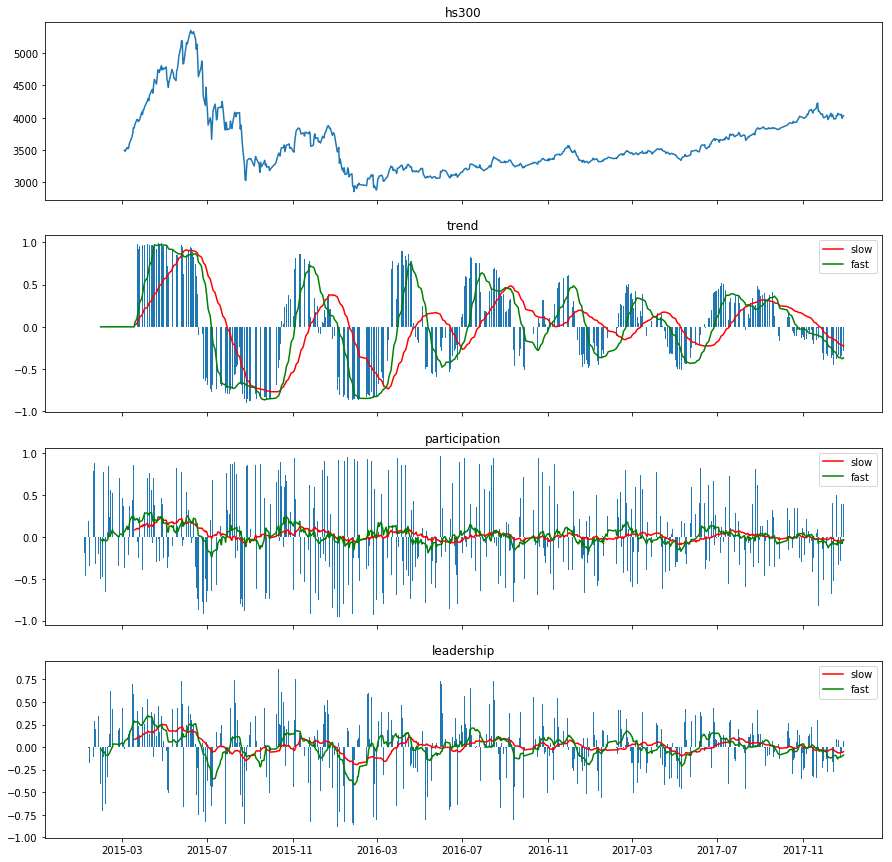

In [13]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 15))

axs[0].set_title("hs300")
axs[0].plot(hs300['close'].loc['2015-03-05':])

to_smooth = ["trend", "participation", "leadership"]

for ax, (name, item) in zip(axs[1:], hs300[to_smooth].iteritems()):
    plot_smooth(ax, smooth(item), item)

plt.show()